# ECE 4250 Milestone 2

In [1]:
import numpy as np
import nibabel as nib
import scipy
from scipy import ndimage, signal, stats
from scipy.optimize import fmin
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import math
import cmath
import cv2
from cv2 import warpAffine
from scipy.interpolate import RegularGridInterpolator
from IPython.display import HTML, display
import tabulate

In [11]:
temp = [100,100,50,50]
hello = stats.mode(temp)
hello[0]

array([50])

### Reading the data

In [2]:
training_img , training_sgm, validation_img , validation_sgm, testing_img = [], [], [], [], []

loc_validation_img, loc_validation_sgm = ['./4250-Data/Validation/IBSR_'+ i + '/images/analyze/IBSR_' + i +'_ana.img' for i in ['07', '15']],['./4250-Data/Validation/IBSR_'+ i + '/segmentation/analyze/IBSR_' + i +'_seg_ana.img' for i in ['07', '15']]

loc_training_img, loc_training_sgm  = ['./4250-Data/Training/IBSR_0'+ str(i) + '/images/analyze/IBSR_0' + str(i) +'_ana.img' for i in range(1,7)],['./4250-Data/Training/IBSR_0'+ str(i) + '/segmentation/analyze/IBSR_0' + str(i) +'_seg_ana.img' for i in range(1,7)]

loc_testing_img , temp = [], ['08','09','10','11','12','13','14','16','17']

for i in temp:
    loc_testing_img.append('./4250-Data/Testing/IBSR_'+ i + '/images/analyze/IBSR_' + i + '_ana.img')
    
def Sliced(img): ## input is of typpe nibabel image 
    img_data = img.get_fdata()
    slicing = img_data[:, :, int(len(img_data[0,0])/2) ]
    return rotate(slicing, 90)


for i in range(len(loc_validation_img)):
    validation_img.append(Sliced(nib.load(loc_validation_img[i])))
    validation_sgm.append(Sliced(nib.load(loc_validation_sgm[i])))

for i in range(len(loc_training_img)):
    training_img.append(Sliced(nib.load(loc_training_img[i])))
    training_sgm.append(Sliced(nib.load(loc_training_sgm[i])))

for i in loc_testing_img:
    testing_img.append(Sliced(nib.load(i)))




### Part 1

Write a function that computes a 4-parameter geometric registration (global scale, rotation, and translations along two axes) between two mid-coronal MRI slices from two different subjects (a fixed image and a moving image). This step will consist of following sub-steps.
- a function that takes in an input (moving) image, 4 transformation parameters (global scale, rotation, and translations along two axes) and output (fixed image) grid size, and computes the output (moved) image. The output image has a size of the output grid size and pixel values are obtained by resampling the input image onto the output grid via applying the geometric transformation: a global scale multiplied with a rotation matrix, followed by a translation. Outside-of-grid-range values can default to zero.

- a loss function that takes three inputs: a length-4 vector of geometric transformation parameters, a fixed image, and a moving image. The output should be equal to the sum of squared differences between the geometrically transformed moved image and the fixed image.

- an optimization module that minimizes the loss function for a given input image pair (fixed and moving). This module should return two things: the transformed moving image and the optimal geometric transformation parameters.

In [3]:
## function that takes in an input (moving) image, 4 transformation parameters 
## (global scale, rotation, and translations along two axes) and output (fixed image) 
## grid size, and computes the output (moved) image. 

def Trnsfrm(mv_img, glbl_scale, theta, t_x, t_y, grid_size_out):

    dim_1, dim_2, dim_3, dim_4 = len(mv_img[0]), len(mv_img),grid_size_out[1], grid_size_out[0]
    
    Aff_mt_1, Aff_mt_2 = cv2.getRotationMatrix2D((dim_1//2,dim_2//2),theta,glbl_scale), np.float32([[1,0,t_x], [0,1,t_y]]) 
    sc_rot_img = warpAffine(mv_img,Aff_mt_1,(dim_1,dim_2)) #apply the affine matrix 1 to input moving image
    

    img_trns = warpAffine(sc_rot_img,Aff_mt_2,(dim_3,dim_4)) 

    return img_trns


## loss function that takes three inputs: a length-4 vector of geometric transformation 
## parameters, a fixed image, and a moving image. 

def Loss(Trns_par, fix_img, mv_img):    
    geom = Trnsfrm(mv_img, *Trns_par, fix_img.shape) # Geometrically transformed img on basis of input param
    
    temp_1 = np.array(np.ndarray.flatten(geom))
    temp_2 = np.array(np.ndarray.flatten(fix_img))
    ret = np.zeros(len(temp_1))
    ret= np.sum((temp_1-temp_2)**2)       
    ret = ret/(10 ** 8)
    return ret



## optimization module that minimizes the loss function for a given input image pair (fixed and moving). 
## Returns two things: the transformed moving image and the optimal geometric transformation parameters.

def optmzer(fix_img, mv_img):
    norm_1, norm_2 =np.zeros((fix_img.shape[0], fix_img.shape[1])), np.zeros((fix_img.shape[0], fix_img.shape[1])) 
    norm_fix_img = cv2.normalize(fix_img, norm_1, 0, 255, cv2.NORM_MINMAX)
    norm_mv_img = cv2.normalize(mv_img, norm_2, 0, 255, cv2.NORM_MINMAX)
    opt_par = fmin(Loss, (1,0,0,0), args=(norm_fix_img, norm_mv_img))
    transf_img = Trnsfrm(norm_mv_img, *opt_par, norm_fix_img.shape)
    return transf_img, opt_par
    
    

###  Part 2

Use your registration tool to resample each training image (moving) onto each validation image (fixed) (i.e., you need to run 12 registration instances). Visualize some slices of these results. You need to show that your registration works - i.e., plot results for before the registration and after the registration.

In [4]:
opt_par = [optmzer(i,j)[1] for i in validation_img for j in training_img]
transf_img = [optmzer(i,j)[0] for i in validation_img for j in training_img]
reg_img = np.zeros((6,256,256, 2))
## reg_img stores the resampled training image on two validation images- 07 and 15 respectively

reg_img[:,:,:,0], reg_img[:,:,:,1]= [Trnsfrm(training_img[i], *opt_par[i], validation_img[0].shape) for i in range(6)], [Trnsfrm(training_img[j], *opt_par[6+j], validation_img[1].shape) for j in range (6)]

Optimization terminated successfully.
         Current function value: 0.438100
         Iterations: 39
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 0.485059
         Iterations: 37
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 0.703899
         Iterations: 40
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 0.856039
         Iterations: 31
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 0.573507
         Iterations: 40
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 0.677521
         Iterations: 36
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 0.543563
         Iterations: 36
         Function evaluations: 78
Optimization terminated successful

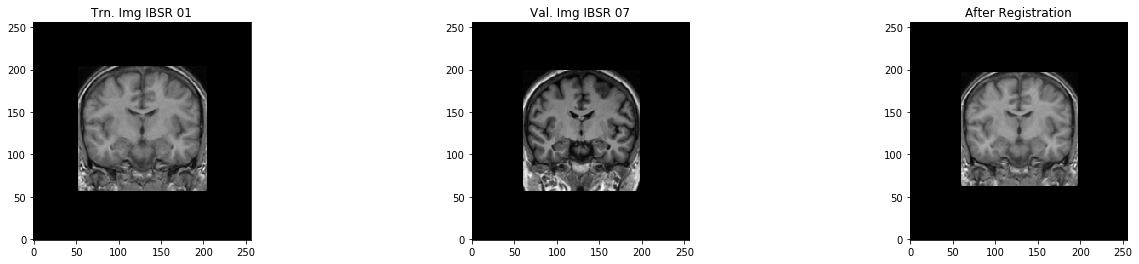

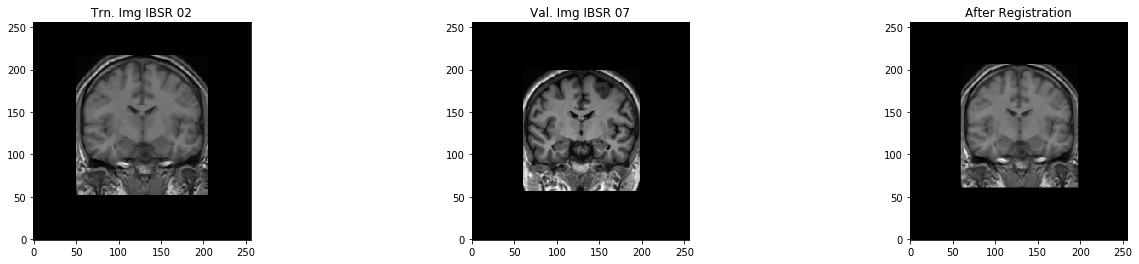

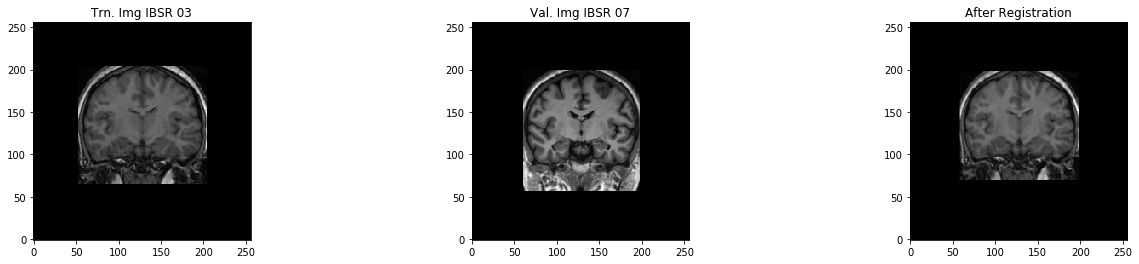

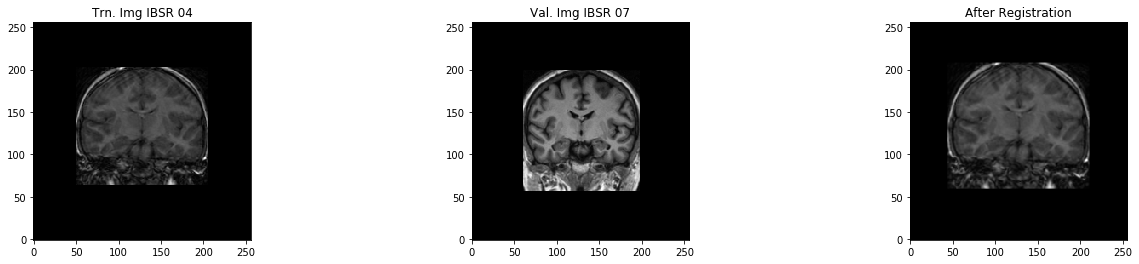

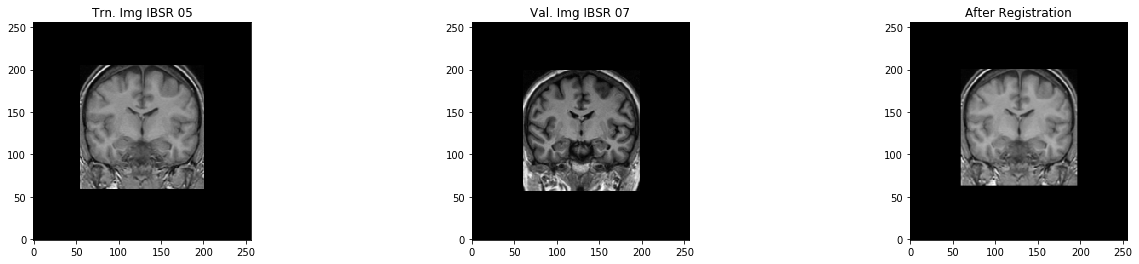

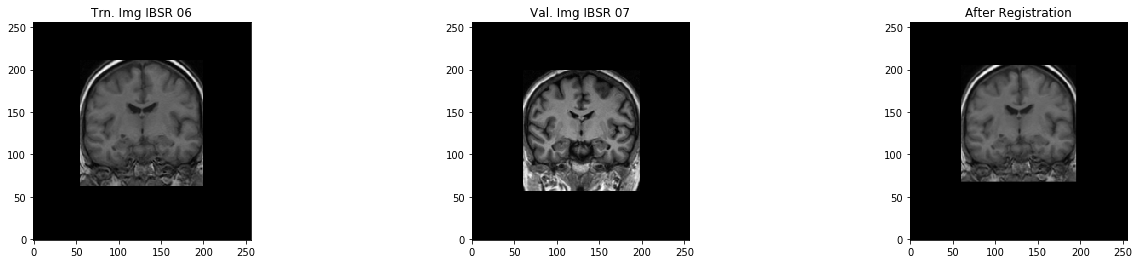

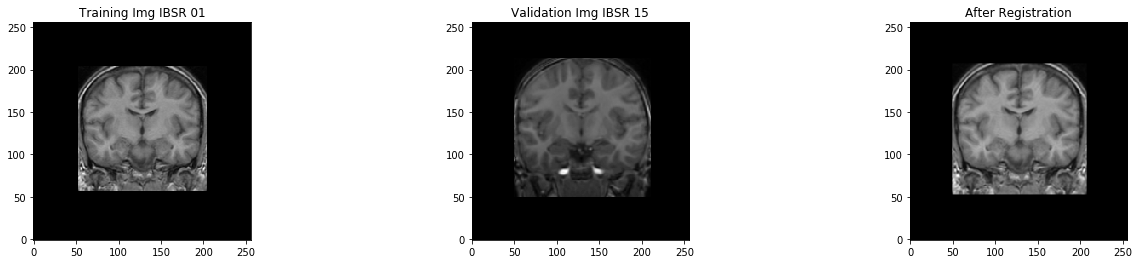

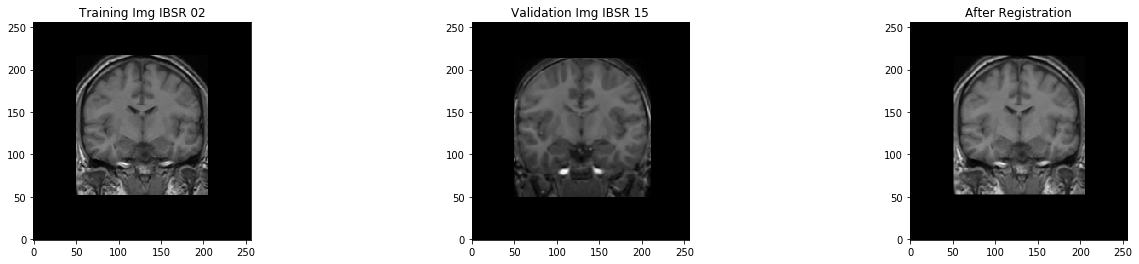

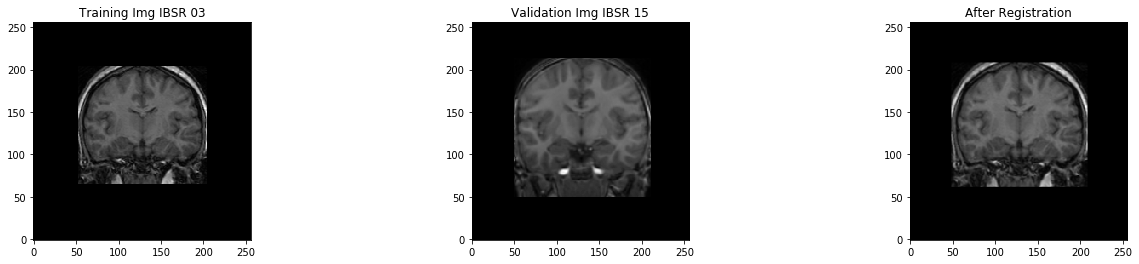

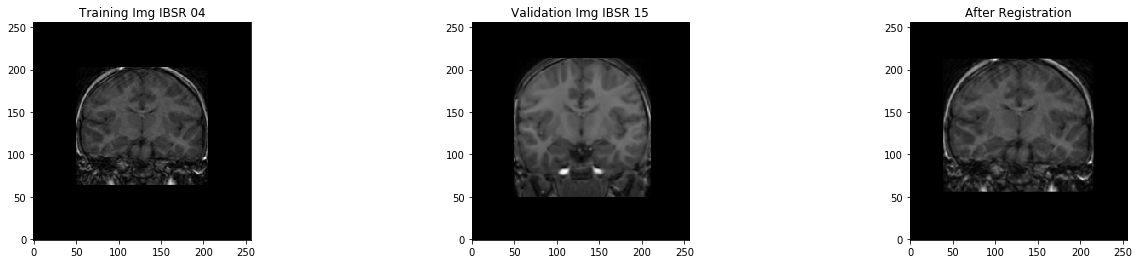

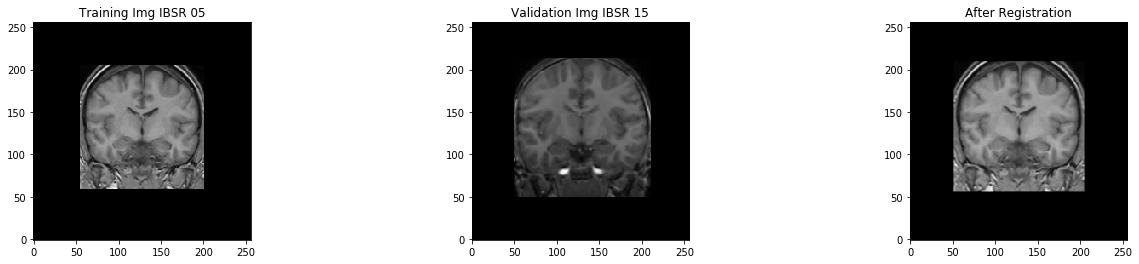

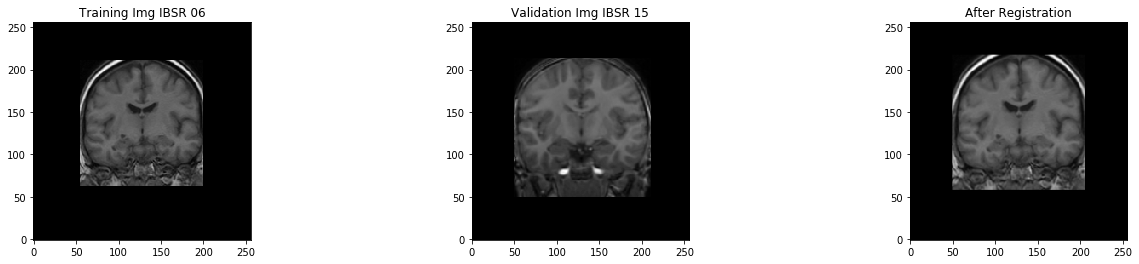

In [5]:
## Visualizing the results

for i in range(6):
    fix, ax = plt.subplots(1, 3)

    ax[0].imshow(training_img[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[0].set_title('Trn. Img IBSR 0' + str(i+1))
    
    ax[1].imshow(validation_img[0].squeeze(), cmap = 'gray', origin = 'lower')
    ax[1].set_title('Val. Img IBSR 07')
    
    ax[2].imshow(reg_img[i, :, :, 0].squeeze(), cmap = 'gray', origin = 'lower')
    ax[2].set_title('After Registration')
    
    plt.subplots_adjust(right = 3)
    
for i in range(6):
    fix, ax = plt.subplots(1, 3)
   
    ax[0].imshow(training_img[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[0].set_title('Training Img IBSR 0' + str(i+1))
    
    ax[1].imshow(validation_img[1].squeeze(), cmap = 'gray', origin = 'lower')
    ax[1].set_title('Validation Img IBSR 15')
    
    ax[2].imshow(reg_img[i, :, :, 1].squeeze(), cmap = 'gray', origin = 'lower')
    ax[2].set_title('After Registration')
    plt.subplots_adjust(right = 3)


plt.show()

### Part 3

Apply the registration results (optimal transformations) to resample the manual segmentations of each training subject onto the validation subject grids (use nearest neighbor interpolation)

In [6]:
## Using nearest neighbor interpolation

## function that translates the input image by t_x, t_y coordinates using nn interpolation

def Trns_NN(img, t_x, t_y):
    grid_val = np.linspace(-1 * img.shape[0] // 2, img.shape[0] // 2, img.shape[0])
    temp = np.array(np.meshgrid(grid_val,grid_val))
    coor1, coor2 = temp[1] - t_y , temp[0]- t_x ## verify
    NN = RegularGridInterpolator((grid_val,grid_val), img, method='nearest', bounds_error = False,fill_value=1)
    return NN(np.dstack((coor1, coor2)))


## function that scales the image by global scale using nn interpolation

def scal_NN(img, glb_scale): ## Nearest Neighbor Implementation
    grid_val = np.linspace(-1 * img.shape[0] // 2, img.shape[0] // 2, img.shape[0])
    
    temp = np.array(np.meshgrid(grid_val,grid_val))
    coor1, coor2 = temp[1]/glb_scale , temp[0]/glb_scale
    NN = RegularGridInterpolator((grid_val,grid_val), img, method='nearest', bounds_error = False,fill_value=1)
    return NN(np.dstack((coor1, coor2)))

## Function that rotates input image clockwise by input angle theta using nn interpolation

def Rotate2DMatrix_NN(img, theta): ## Nearest Neighbor Implementation
    alpha, beta = np.cos(theta*np.pi/180),  np.sin(theta*np.pi/180)
    
    grid_val = np.linspace(-1 * img.shape[0] // 2, img.shape[0] // 2, img.shape[0])
    
    temp = np.array(np.meshgrid(grid_val,grid_val))
    
    coor1, coor2 = alpha*temp[1] -beta*temp[0], beta*temp[1] + alpha*temp[0]
    
    NN = RegularGridInterpolator((grid_val,grid_val), img, method='nearest', bounds_error = False,fill_value=1)
    return NN(np.dstack((coor1, coor2)))


## function that takes in an input (moving) image, 4 transformation parameters 
## (global scale, rotation, and translations along two axes) and output (fixed image) 
## grid size, and computes the output (moved) image using nearest neighbor interpolation. 


def Trnsfrm_NN(mv_img, glbl_scale, theta, t_x, t_y,grid_size_out ):
    final_img = Trns_NN(scal_NN(Rotate2DMatrix_NN(mv_img, -theta), glbl_scale), t_x, t_y).reshape(mv_img.shape)

    dim_1, dim_2, dim_3, dim_4 = len(final_img[0]), len(final_img),grid_size_out[1], grid_size_out[0]
    
    Aff_mt_2 =  np.float32([[1,0,0], [0,1,0]])  

    img_trns = warpAffine(final_img,Aff_mt_2,(dim_3,dim_4)) 

    return img_trns



In [7]:
opt_par = [optmzer(i,j)[1] for i in validation_sgm for j in training_sgm]
transf_img = [optmzer(i,j)[0] for i in validation_sgm for j in training_sgm]
reg_img_sgm = np.zeros((6,256,256, 2))

## reg_img_sgm stores the resampled training segment on two validation segments- 07 and 15 respectively

reg_img_sgm[:,:,:,0], reg_img_sgm[:,:,:,1]= [Trnsfrm_NN(training_sgm[i], *opt_par[i], validation_sgm[0].shape) for i in range(6)], [Trnsfrm_NN(training_sgm[j], *opt_par[6+j], validation_sgm[1].shape) for j in range (6)]





Optimization terminated successfully.
         Current function value: 0.127227
         Iterations: 36
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 0.253321
         Iterations: 48
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: 0.219082
         Iterations: 48
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: 0.212552
         Iterations: 29
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 0.199017
         Iterations: 38
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 0.193344
         Iterations: 37
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 0.296019
         Iterations: 34
         Function evaluations: 76
Optimization terminated successf

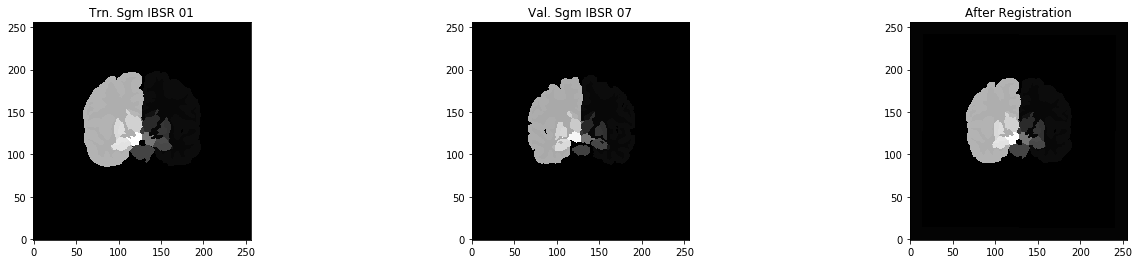

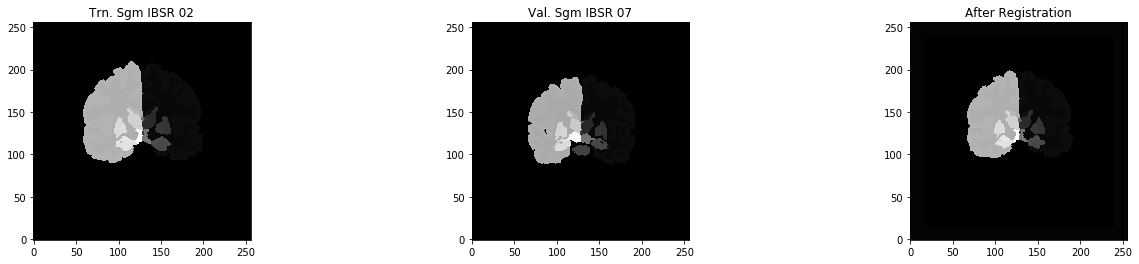

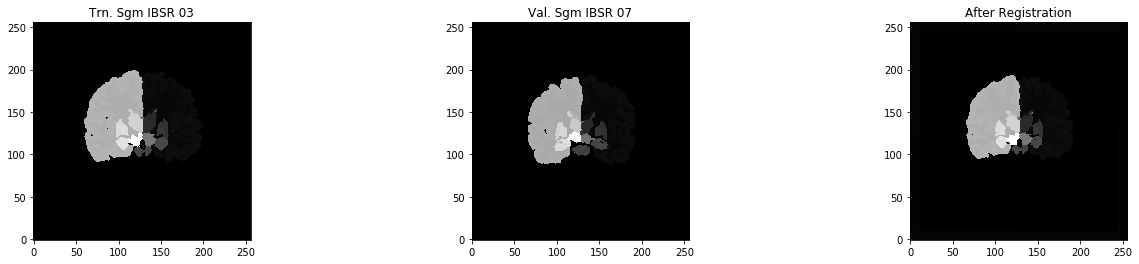

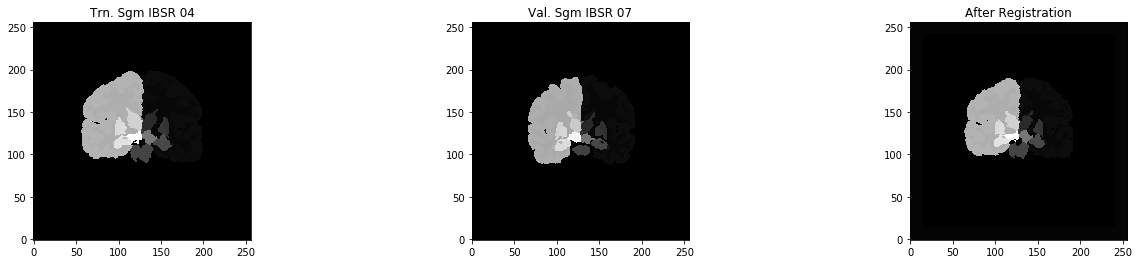

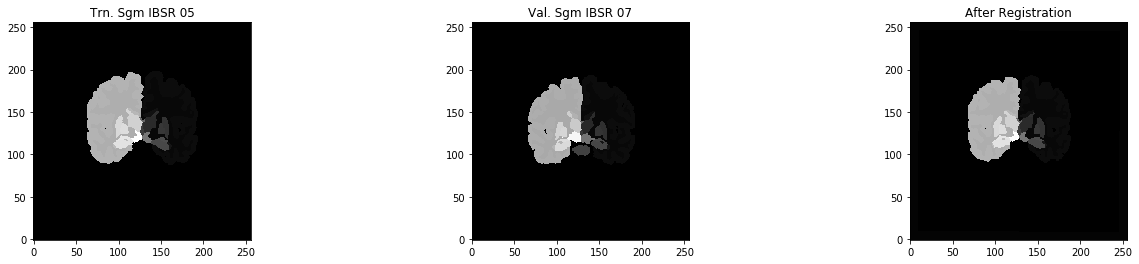

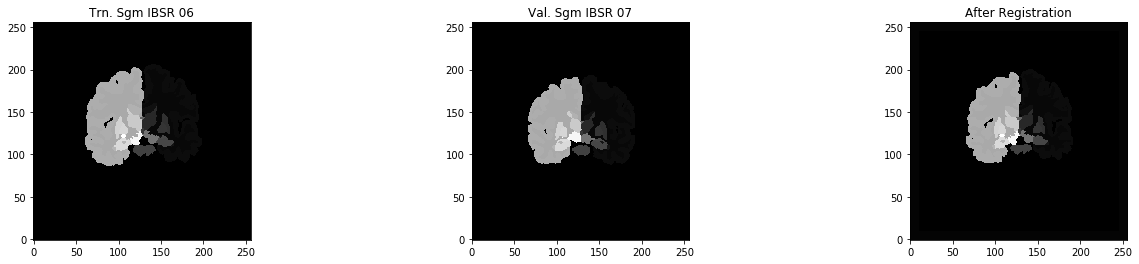

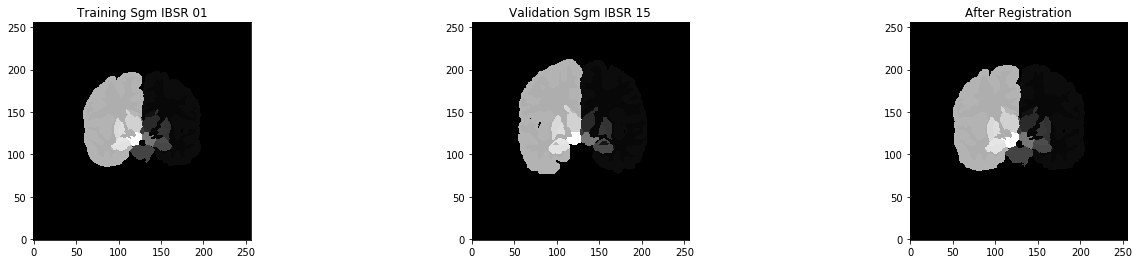

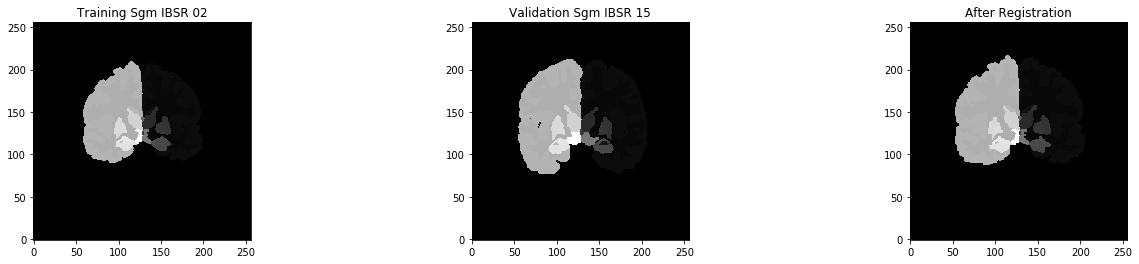

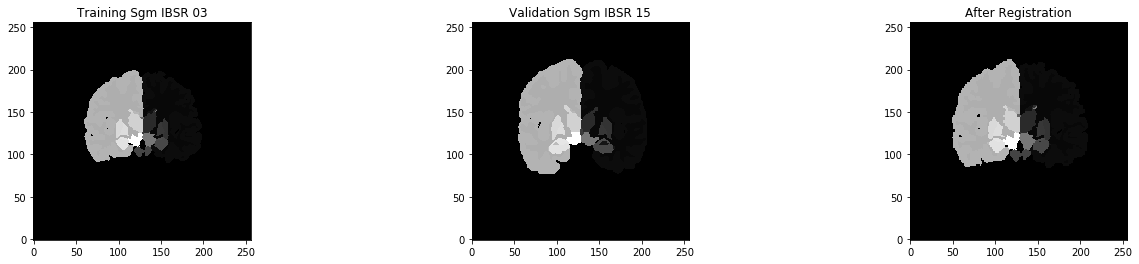

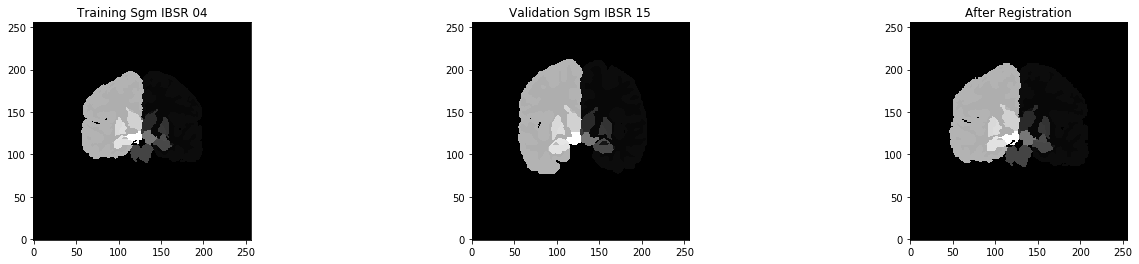

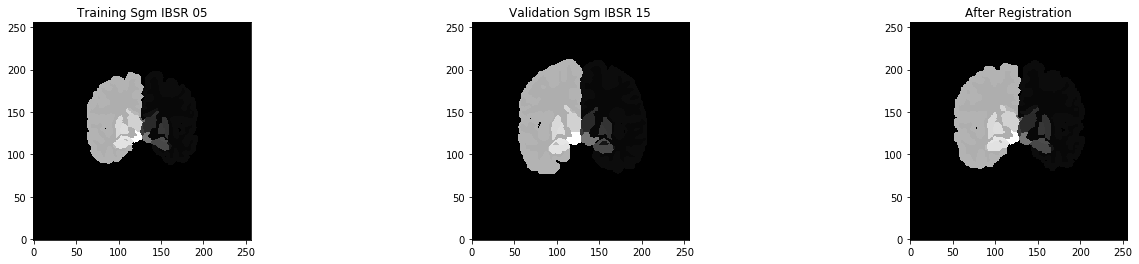

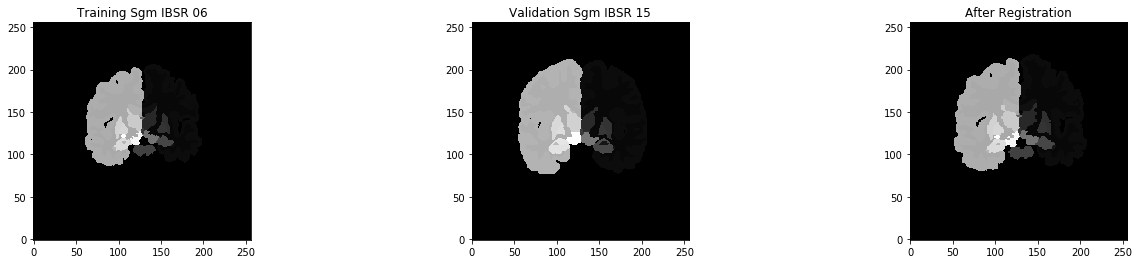

In [8]:
## Visualizing the results

for i in range(6):
    fix_ax, ax = plt.subplots(1, 3)

    ax[0].imshow(training_sgm[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[0].set_title('Trn. Sgm IBSR 0' + str(i+1))
    
    ax[1].imshow(validation_sgm[0].squeeze(), cmap = 'gray', origin = 'lower')
    ax[1].set_title('Val. Sgm IBSR 07')
    
    ax[2].imshow(reg_img_sgm[i, :, :, 0].squeeze(), cmap = 'gray', origin = 'lower')
    ax[2].set_title('After Registration')
    
    plt.subplots_adjust(right = 3)
    
for i in range(6):
    fix_ax, ax = plt.subplots(1, 3)
   
    ax[0].imshow(training_sgm[i].squeeze(), cmap = 'gray', origin = 'lower')
    ax[0].set_title('Training Sgm IBSR 0' + str(i+1))
    
    ax[1].imshow(validation_sgm[1].squeeze(), cmap = 'gray', origin = 'lower')
    ax[1].set_title('Validation Sgm IBSR 15')
    
    ax[2].imshow(reg_img_sgm[i, :, :, 1].squeeze(), cmap = 'gray', origin = 'lower')
    ax[2].set_title('After Registration')
    plt.subplots_adjust(right = 3)


plt.show()

### Part 4
For every pixel on validation subject grid, compute the most frequent training label - this is called majority voting based label fusion. You can implement any tie-break strategy you want. This is a crude segmentation of the validation
subjects.

In [9]:
print(np.shape(reg_img_sgm))

(6, 256, 256, 2)


In [10]:
## function that computes the most frequent training label for every pixel on validation grid

def High_Freq(reg_img):
    ret = np.zeros((256, 256), dtype = 'float')
    
    for i in range(256):
        for j in range(256):
            ret[i,j] = stats.mode([reg_img[ind][i][j] for ind in range(6)])[0]
    
    return ret



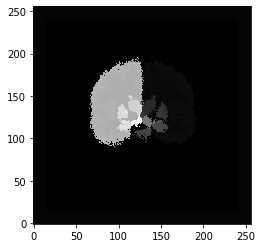

In [11]:
## test
hfreq1 = High_Freq(reg_img_sgm[:,:,:,0]) ## computes the most frequent training label for validation grid-07
plt.imshow(hfreq1, cmap = 'gray', origin = 'lower')



### Part 5

Write a function that computes the Jaccard overlap index for a given region of
interest (ROI) between an input manual segmentation and an automatic segmentation. The Jaccard index is defined as the ratio between the area of the intersection and the area of the union, where the intersection and union are defined with respect to the manual segmentation and an automatic segmentation.

In [12]:
## function that computes the Jaccard overlap index for a gien ROI between an input manual segmentation
## and an automatic segmentation. 

def Jaccard(man_sgm, auto_sgm, ROI):

    man_sgm_1, auto_sgm_1 = np.round(np.array(np.ndarray.flatten(man_sgm), dtype = 'int')), np.round(np.array(np.ndarray.flatten(auto_sgm), dtype = 'int'))
    match_1, match_2 = (man_sgm_1 == ROI), (auto_sgm_1 == ROI)
    
    Un, Inter =  np.logical_or(match_1, match_2), np.logical_and(match_2,match_1) ## Calculate the Union and Intersection
    
    ret = (np.sum(Inter))/(np.sum(Un)) ## Taking the ratio of Intersection and Union values
    return ret


### Part 6
Compute the Jaccard index for your automatic validation subject segmentations. Compile these in a table and print. Only consider following regions of interest (both left and right): Cerebral-White-Matter and Cerebral-Cortex.

In [13]:
print('ROI = 2 | Left cerebral white matter') 


hfreq1, hfreq2 = High_Freq(reg_img_sgm[:,:,:,0]) , High_Freq(reg_img_sgm[:,:,:,1]) 
print('for validation sgm 07') 
print(Jaccard(hfreq1,validation_sgm[0],2))
print('for validation sgm 15') 
print(Jaccard(hfreq2,validation_sgm[1],2))

ROI = 2 | Left cerebral white matter
for validation sgm 07
0.5072748721981911
for validation sgm 15
0.5396593673965937


In [14]:
print('ROI = 41 | Right cerebral white matter') 


hfreq1, hfreq2 = High_Freq(reg_img_sgm[:,:,:,0]) , High_Freq(reg_img_sgm[:,:,:,1]) 
print('for validation sgm 07') 
print(Jaccard(hfreq1,validation_sgm[0],41))
print('for validation sgm 15') 
print(Jaccard(hfreq2,validation_sgm[1],41))

ROI = 41 | Right cerebral white matter
for validation sgm 07
0.48091603053435117
for validation sgm 15
0.5348436345727653


In [15]:
print('ROI = 3 | Left cerebral Cortex')


hfreq1, hfreq2 = High_Freq(reg_img_sgm[:,:,:,0]) , High_Freq(reg_img_sgm[:,:,:,1]) 
print('for validation sgm 07') 
print(Jaccard(hfreq1,validation_sgm[0],3))
print('for validation sgm 15') 
print(Jaccard(hfreq2,validation_sgm[1],3))

ROI = 3 | Left cerebral Cortex
for validation sgm 07
0.4876005361930295
for validation sgm 15
0.5150400346245402


In [16]:
print('ROI = 42 | Right cerebral Cortex')


hfreq1, hfreq2 = High_Freq(reg_img_sgm[:,:,:,0]) , High_Freq(reg_img_sgm[:,:,:,1]) 
print('for validation sgm 07') 
print(Jaccard(hfreq1,validation_sgm[0],42))
print('for validation sgm 15') 
print(Jaccard(hfreq2,validation_sgm[1],42))

ROI = 42 | Right cerebral Cortex
for validation sgm 07
0.4644018792916516
for validation sgm 15
0.5502293577981652


In [17]:
## Representing data in tabular form

table = [["Image ", "Left Cerebral White Matter","Left Cerebral Cortex","Right Cerebral White Matter", "Right Cerebral Cortex"],
         ["Val_sgm 07",Jaccard(hfreq1,validation_sgm[0],2),Jaccard(hfreq1,validation_sgm[0],3), Jaccard(hfreq1,validation_sgm[0],41), Jaccard(hfreq1,validation_sgm[0],42)],
         ["Val_sgm 15",Jaccard(hfreq2,validation_sgm[1],2),Jaccard(hfreq2,validation_sgm[1],3), Jaccard(hfreq2,validation_sgm[1],41), Jaccard(hfreq2,validation_sgm[1],42)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Image,Left Cerebral White Matter,Left Cerebral Cortex,Right Cerebral White Matter,Right Cerebral Cortex
Val_sgm 07,0.5072748721981911,0.4876005361930295,0.48091603053435117,0.4644018792916516
Val_sgm 15,0.5396593673965937,0.5150400346245402,0.5348436345727653,0.5502293577981652


___